# Bigmart Sales Prediction

- 회귀 모델로 분석하기

### 필요한 패키지 임포트 하기

In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 전처리

### 데이터 불러오기

In [478]:
df = pd.read_csv('Train.csv', sep=',')
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


### 결측치 처리

In [479]:
df.shape

(8523, 12)

In [480]:
# 결측치 확인 -> 결측치 많은 편 아니므로 대체할 값 선정
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Item_Weight 결측치 -> 평균 무게로 대체

In [481]:
# Item_Weight의 평균값 결측치에 삽입하기
df.Item_Weight.fillna(df.Item_Weight.mean(), inplace=True)
# 변경 후 결측값 확인
df.Item_Weight.isna().sum()

0

- Outlet_Size -> 일반적으로 최빈값 데이터로 대체 but 사이즈 관련이므로 그 중간값인 M으로 대체

In [482]:
# Outlet_Size 컬럼 데이터 별 개수 세기
df.Outlet_Size.value_counts() # 최빈값 : High 
df.Outlet_Size.fillna('Medium', inplace=True)

In [483]:
# 전체 결측치 다시 확인하기
df.isna().sum().sum()

0

### 카테고리 값인 컬럼 숫자로 변환

- 카테고리 값인 컬럼
    - Item_Fat_Content / Item_Type / Outlet_Size / Outlet_Location_Type / Outlet_Type

#### 1. 카테고리 값인 컬럼 데이터 종류 분석해서 일정하게 맞추기

In [484]:
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [485]:
# Low Fat == low fat, LF / Regular == reg 
df['Item_Fat_Content'].replace(['low fat', 'LF', 'reg'], ['Low Fat', 'Low Fat', 'Regular'], inplace=True)
# 데이터 변경 적용되었는지 확인
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### 2. 카테고리 값인 컬럼 인코딩 하기

In [486]:
# Label Encoder 로 변환 -> 객체 생성
# Label Encoder 는 1차원 입력
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [487]:
# 데이터 인코딩
df.Item_Identifier = le.fit_transform(df.Item_Identifier)
df.Item_Fat_Content = le.fit_transform(df.Item_Fat_Content)
df.Item_Type = le.fit_transform(df.Item_Type)
df.Outlet_Identifier = le.fit_transform(df.Outlet_Identifier)
df.Outlet_Size = le.fit_transform(df.Outlet_Size)
df.Outlet_Location_Type = le.fit_transform(df.Outlet_Location_Type)
df.Outlet_Type = le.fit_transform(df.Outlet_Type)
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700


In [488]:
# 인코딩 상태 확인하기
print(np.unique(df.Item_Identifier, return_counts=True))
print(np.unique(df.Item_Fat_Content, return_counts=True)) # Low Fat(0) / Regular(1)
print(np.unique(df.Item_Type, return_counts=True))
print(np.unique(df.Outlet_Identifier, return_counts=True))
print(np.unique(df.Outlet_Size, return_counts=True)) # High(0) / Medium(1) / Small(2)
print(np.unique(df.Outlet_Location_Type, return_counts=True)) # Tier 3(0) / Tier 2(1) / Tier1(2)
print(np.unique(df.Outlet_Type, return_counts=True)) # Grocery Store(0) / Supermarket Type1(1) / Supermarket Type2(2) / Supermarket Type3(3)

(array([   0,    1,    2, ..., 1556, 1557, 1558]), array([6, 7, 8, ..., 5, 5, 7], dtype=int64))
(array([0, 1]), array([5517, 3006], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 648,  251,  110,  649,  682,  856, 1232,  214,  520,  910,  425,
        169,   64, 1200,  445,  148], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([555, 932, 926, 928, 528, 935, 930, 929, 930, 930], dtype=int64))
(array([0, 1, 2]), array([ 932, 5203, 2388], dtype=int64))
(array([0, 1, 2]), array([2388, 2785, 3350], dtype=int64))
(array([0, 1, 2, 3]), array([1083, 5577,  928,  935], dtype=int64))


In [489]:
# 인코딩 전 원래의 값을 확인하는 방법
# print(le.classes_)

In [490]:
# 다른 인코딩 방법

# pandas의 get_dummies() 함수 사용
# pd.get_dummies(df)

# sklearn의 One Hot Encoding
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# ohe.fit_transform(df)

#### 3. 컬럼 (Outlet_Establishment_Year -> Outlet_Age) 조작하기

- 아울렛이 얼마나 오래되었는지 나타내는 컬럼으로 바꾸기

In [491]:
df['Outlet_Establishment_Year'] = df.Outlet_Establishment_Year.apply(lambda year : 2021 - year)

In [492]:
df.rename(columns={'Outlet_Establishment_Year': 'Outlet_Age'}, inplace=True)
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,22,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,12,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,22,1,0,1,2097.2700


### 전체 데이터 시각화

In [493]:
# 필요한 컬럼만 들고오기
df.drop(columns=['Item_Identifier'], inplace=True)
df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,9,22,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,3,12,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,9,22,1,0,1,2097.2700


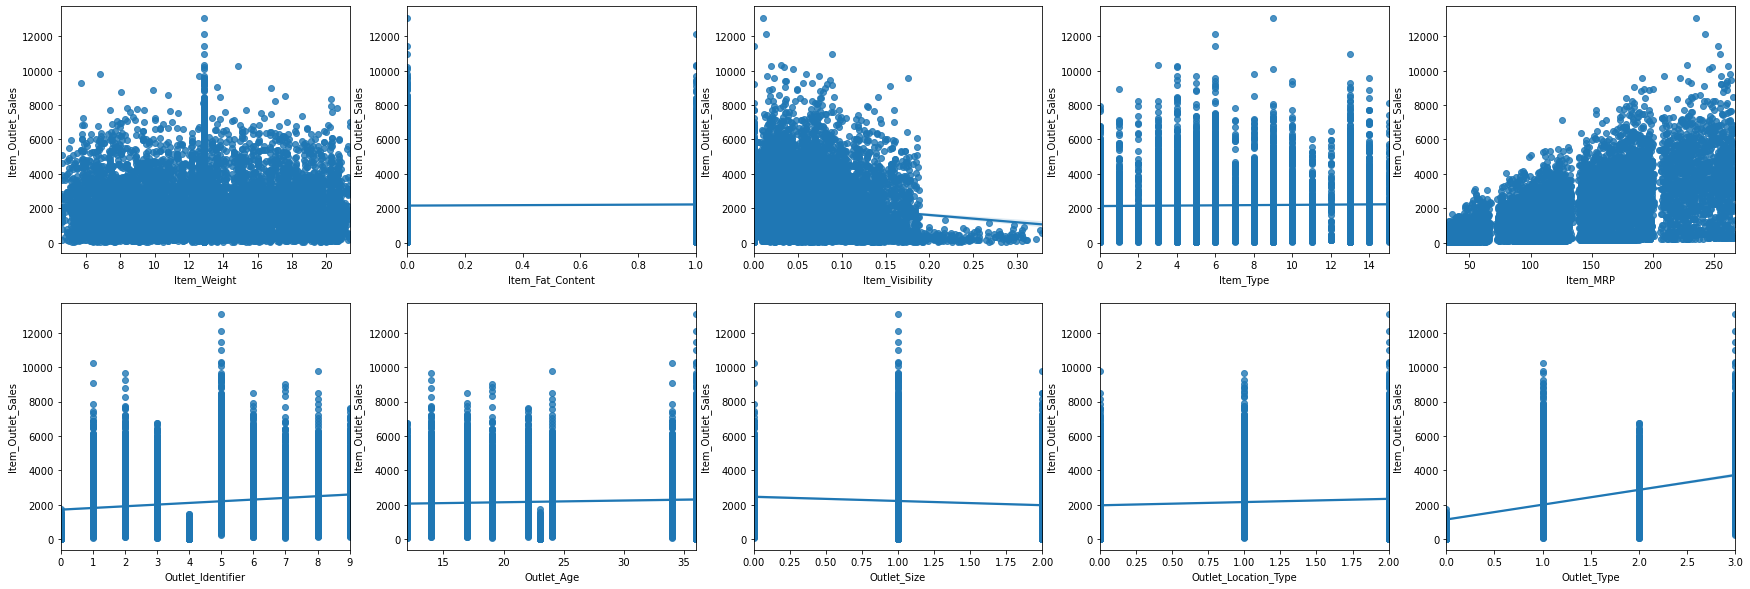

In [494]:
_, axs = plt.subplots(nrows=2, ncols=5, figsize=(30,10))           
for i, feature in enumerate(df.columns[:-1]):                     
    row, col = i//5, i%5                                            
    sns.regplot(x=feature, y='Item_Outlet_Sales', data=df, ax=axs[row][col])

## 단순선형회귀

### 회귀선 그리기

#### 주제1. Item_Visibility vs. Item_Outlet_Sales

- 상품의 디스플레이 비중에 따른 매출액 추이

In [495]:
item_visibility = df.Item_Visibility.values.reshape(-1,1)    # X 값
sales_amount = df.Item_Outlet_Sales.values   # target(label) 값
item_visibility.shape, sales_amount.shape

((8523, 1), (8523,))

In [496]:
# 학습 / 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    item_visibility, sales_amount, test_size=0.1, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 1), (853, 1), (7670,), (853,))

In [497]:
# 학습 데이터로 훈련 및 예측
from sklearn.linear_model import LinearRegression   # 단순선형회귀
lr = LinearRegression()
lr.fit(X_train, y_train)    # 학습 데이터로 훈련 
lr.score(X_test, y_test)    # 테스트 데이터에 대한 정확도

0.016302341439267676

- 시각화

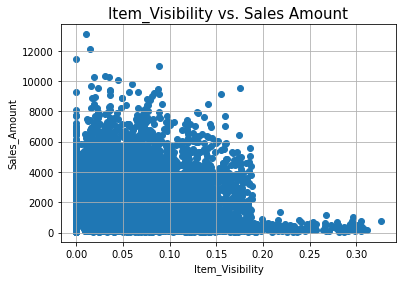

In [498]:
# 산점도 시각화
plt.scatter(X_train, y_train)
plt.grid()
plt.xlabel('Item_Visibility')
plt.ylabel('Sales_Amount')
plt.title('Item_Visibility vs. Sales Amount', fontsize=15)
plt.show()

- 회귀선 구하기

In [499]:
# 회귀선의 계수 / 절편
lr.coef_, lr.intercept_

(array([-4258.3142543]), 2459.823415395422)

In [500]:
# 회귀선 식 구하기
xs = np.array([0, 0.34])    # x값 = 독립변수
ys = xs * lr.coef_ + lr.intercept_ # lr.coef_ : weight / lr.intercept_ : bias
ys

array([2459.8234154 , 1011.99656893])

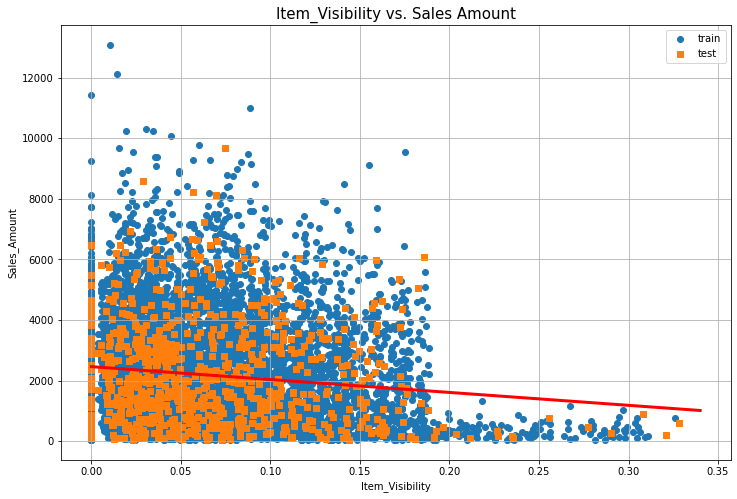

In [501]:
# 산점도 + 회귀선
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, marker='s', label='test')
plt.plot(xs, ys, 'r-', lw=3)
plt.grid()
plt.xlabel('Item_Visibility')
plt.ylabel('Sales_Amount')
plt.title('Item_Visibility vs. Sales Amount', fontsize=15)
plt.legend()
plt.show()

- 회귀선 그릴 수 있는 다른 방법 - numpy의 polyfit
    - LinearRegression과의 차이점 : 모든 데이터를 대상으로 함

In [502]:
weight, bias = np.polyfit(df.Item_Visibility, df.Item_Outlet_Sales, 1)     # x 값, y 값, 몇 차식 회귀선인가 
weight, bias

(-4254.013860556849, 2462.615480627435)

In [503]:
xs = np.array([0, 0.34])
ys = xs * weight + bias
ys      # 양극단의 점에 대한 y 값

array([2462.61548063, 1016.25076804])

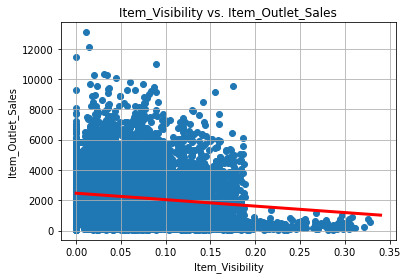

In [504]:
# matplotlib 으로 그리기
plt.scatter(df.Item_Visibility, df.Item_Outlet_Sales)
plt.plot(xs, ys, 'r-', lw=3)
plt.grid()
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title('Item_Visibility vs. Item_Outlet_Sales')
plt.show()

#### 주제2. Item_MRP vs. Item_Outlet_Sales

- 상품의 최대 가격에 따른 매출액 추이

In [505]:
item_mrp = df.Item_MRP.values.reshape(-1,1)    # X 값
sales_amount = df.Item_Outlet_Sales.values   # target(label) 값
item_mrp.shape, sales_amount.shape

((8523, 1), (8523,))

In [506]:
# 학습 / 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    item_mrp, sales_amount, test_size=0.1, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 1), (853, 1), (7670,), (853,))

In [507]:
# 학습 데이터로 훈련 및 예측
from sklearn.linear_model import LinearRegression   # 단순선형회귀
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
lr2.score(X_test, y_test)

0.3577367806660219

- 시각화

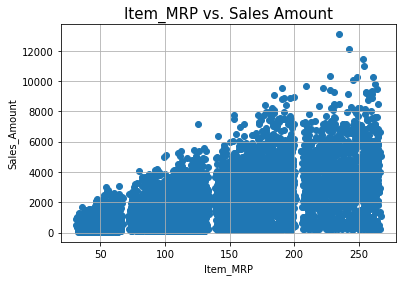

In [508]:
# 산점도 시각화
plt.scatter(X_train, y_train)
plt.grid()
plt.xlabel('Item_MRP')
plt.ylabel('Sales_Amount')
plt.title('Item_MRP vs. Sales Amount', fontsize=15)
plt.show()

- 회귀선 구하기

In [509]:
# 계수 / 절편
lr2.coef_, lr2.intercept_

(array([15.48478217]), -4.672751774833159)

In [510]:
xs2 = np.array([20, 270])
ys2 = xs2 * lr2.coef_ + lr2.intercept_
ys2

array([ 305.02289157, 4176.21843342])

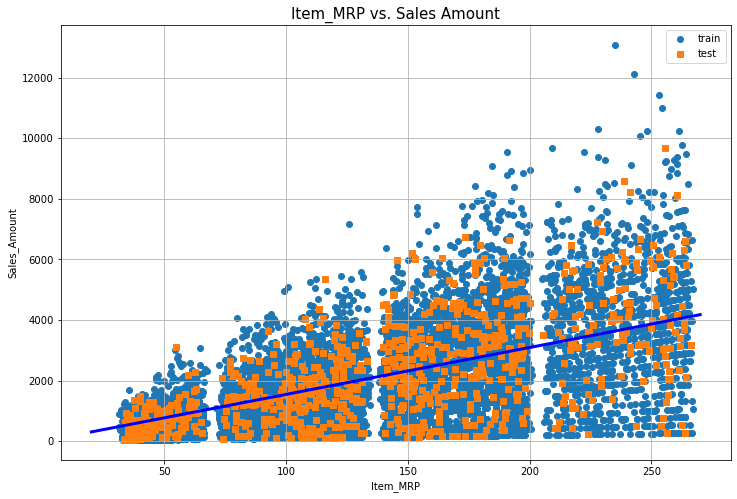

In [511]:
# 산점도 + 회귀선
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, marker='s', label='test')
plt.plot(xs2, ys2, 'b-', lw=3)
plt.grid()
plt.xlabel('Item_MRP')
plt.ylabel('Sales_Amount')
plt.title('Item_MRP vs. Sales Amount', fontsize=15)
plt.legend()
plt.show()

### 결론

#### 주제1. 상품의 디스플레이 비중에 따른 매출액 추이

- 매장 내 진열 비중이 높은 상품이 반드시 높은 매출을 발생시키는 것은 아니다.
    - 음의 상관관계

#### 주제2. 상품의 최대 가격에 따른 매출액 추이

- 최대 가격(정가)이 높은 상품일수록 매출액이 큰 경향이 있다.
    - 양의 상관관계

### 결과

- 상품의 디스플레이 비중보다 상품의 최대 가격이 매출액을 증가시키는 주요 요인이다.
    - 가격이 높은 상품은 그렇지 않은 상품보다 적게 팔려도 기본 단가가 높기 때문에 '매출액'을 기준으로 분석했을 때 보다 높은 매출을 기록할 가능성이 크기 때문이다.
    - 따라서, 이를 고려해서 데이터를 분석해야 의미있는 결과가 나올 수 있다.
        - 예를 들면, ( 매출액(Item_Outlet_Sales) / 상품의 최대 가격(Item_MRP) ) 의 결과인 '판매된 상품의 개수'를 비교하는 식으로 비교 기준을 보다 명확히 해주는 과정이 필요하다.

### 보고서의 결과 반영하여 데이터 조작 및 재분석하기

- 상품 판매 개수 컬럼 추가

In [512]:
# 원하는 위치에 컬럼 추가 : 데이터프레임.insert(원하는 컬럼의 위치, 새롭게 들어갈 컬럼의 이름, 데이터 조건)
df.insert(5, 'The_Number_Of_Sales', round(df.Item_Outlet_Sales / df.Item_MRP))

In [513]:
df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,The_Number_Of_Sales,Outlet_Identifier,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,15.0,9,22,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,9.0,3,12,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,15.0,9,22,1,0,1,2097.2700


#### 주제3. The_Number_Of_Sales vs. Item_Outlet_Sales  

- 판매 개수에 따른 매출액 추이
    - 판매 개수 = 매출액 / 상품의 최대 가격

In [514]:
the_num_of_sales = df.The_Number_Of_Sales.values.reshape(-1,1) # X 값
sales_amount = df.Item_Outlet_Sales.values      # target(label) 값
the_num_of_sales.shape, sales_amount.shape

((8523, 1), (8523,))

In [515]:
# 학습 / 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    the_num_of_sales, sales_amount, test_size=0.1, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 1), (853, 1), (7670,), (853,))

In [516]:
# 학습 데이터로 훈련 및 예측
from sklearn.linear_model import LinearRegression
lr3 = LinearRegression()
lr3.fit(X_train, y_train)
lr3.score(X_test, y_test)
  

0.5656256245846032

- 시각화

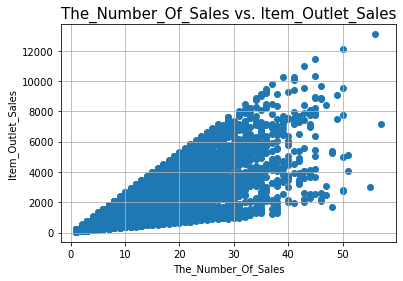

In [517]:
# 산점도 시각화
plt.scatter(X_train, y_train)
plt.grid()
plt.xlabel('The_Number_Of_Sales')
plt.ylabel('Item_Outlet_Sales')
plt.title('The_Number_Of_Sales vs. Item_Outlet_Sales', fontsize=15)
plt.show()

- 회귀선 구하기

In [518]:
# 계수 / 절편
lr3.coef_, lr3.intercept_

(array([141.09159054]), 3.5338720166155326)

In [519]:
xs3 = np.array([0, 57])
ys3 = xs3 * lr3.coef_ + lr3.intercept_
ys3

array([3.53387202e+00, 8.04575453e+03])

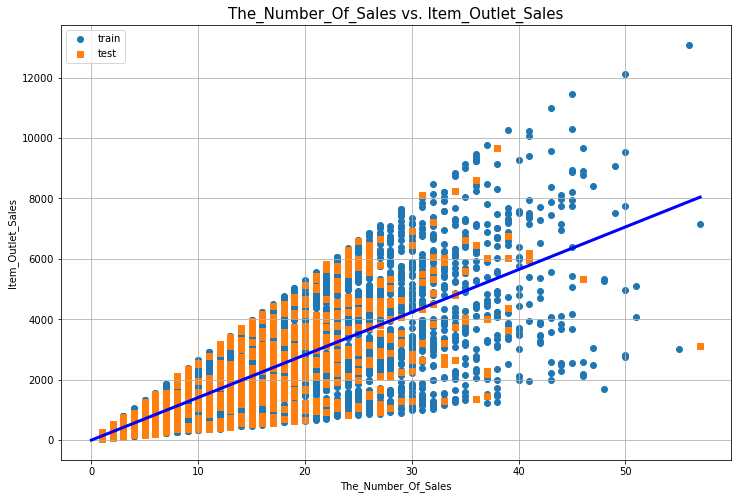

In [520]:
# 산점도 + 회귀선
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, marker='s', label='test')
plt.plot(xs3, ys3, 'b-', lw=3)
plt.grid()
plt.xlabel('The_Number_Of_Sales')
plt.ylabel('Item_Outlet_Sales')
plt.title('The_Number_Of_Sales vs. Item_Outlet_Sales', fontsize=15)
plt.legend()
plt.show()

### 최종 결론

#### 주제3. 판매 개수에 따른 매출액 추이

- 많이 판매된 상품의 매출액이 큰 경향이 있다.
    - 양의 상관관계

### 결과

#### 상품의 최대 가격 / 상품 판매 개수 / 매출액 간의 상관관계 분석

In [521]:
# 필요한 데이터 추출
df1 = df.iloc[:,[4,5,-1]]
df1.head(3)

,Item_MRP,The_Number_Of_Sales,Item_Outlet_Sales
0,249.8092,15.0,3735.1380
1,48.2692,9.0,443.4228
2,141.6180,15.0,2097.2700


In [522]:
# 상관관계 분석
corr_df = df1.corr()

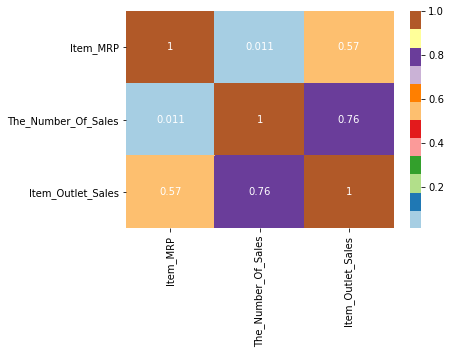

In [523]:
# seaborn 으로 heatmap 그려서 세 변수 간 상관관계 분석
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='w'), cmap='Paired')
plt.show()

##### - 상품의 최대 가격(Item_MRP)과 매출액(Item_Outlet_Sales) : 뚜렷한 양적 상관관계
##### - 상품의 판매 개수(The_Number_Of_Sales)와 매출액(Item_Outlet_Sales) : 강한 양적 상관관계
##### - 상품의 판매 개수(The_Number_Of_Sales)와 상품의 최대 가격(Item_MRP) : 상관관계 거의 없음

## 다중회귀

### 피쳐별 R squared value

- 결정계수 
    - X가 y를 얼마나 설명하는지에 대한 정보 제공 
    - 즉, 회귀식의 정확도
    - 0 ~ 1 사이의 값을 가짐
        - 결정계수 = 1 : 회귀직선으로 y를 완전히 설명 가능. 회귀식의 정확도 매우 높음.
        - 결정계수 = 0 : 추정된 회귀직선은 X와 y의 관계 설명 불가. 회귀식의 정확도 매우 낮음.

In [524]:
# sklearn feature : 2차원 배열구조 사용 - Numpy의 ndarray, Pandas의 DataFrame
# sklearn target : 1차원 벡터 - Numpy의 ndarray, Pandas의 Series
y = df.Item_Outlet_Sales.values 
for feature in df.columns[:-1]:
    X = df[feature].values.reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X,y)
    score = lr.score(X,y)
    print(f'{feature}:\t{score:.4f}')

Item_Weight:	0.0001
Item_Fat_Content:	0.0004
Item_Visibility:	0.0165
Item_Type:	0.0003
Item_MRP:	0.3221
The_Number_Of_Sales:	0.5766
Outlet_Identifier:	0.0263
Outlet_Age:	0.0024
Outlet_Size:	0.0074
Outlet_Location_Type:	0.0080
Outlet_Type:	0.1612


##### ▶ Item_MRP / The_Number_Of_Sales 변수가 y에 대해 어느정도 설명 가능하다는 것을 알 수 있다.

### 학습 / 테스트 데이터셋 분류하기

In [525]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,The_Number_Of_Sales,Outlet_Identifier,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,15.0,9,22,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,9.0,3,12,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,15.0,9,22,1,0,1,2097.2700
3,19.20,1,0.000000,6,182.0950,4.0,0,23,1,2,0,732.3800
4,8.93,0,0.000000,9,53.8614,18.0,1,34,0,2,1,994.7052


In [526]:
X = df.iloc[:, :-1].values
y = df.Item_Outlet_Sales.values

In [527]:
# X = df.drop(columns='Item_Outlet_Sales')
# y = df.Item_Outlet_Sales

In [528]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 11), (1705, 11), (6818,), (1705,))

### 손실함수 - MSE(Mean_Squared_Error) 구하기

- 실제값과 예측값 비교
    - 예측값이 실제값에 가까울수록 MSE가 작은 값이 나온다.

1. LinearRegression

In [529]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)    # 학습 데이터로 훈련
pred_lr = lr.predict(X_test)    # 학습된 분류기로 예측 using 테스트 데이터

In [530]:
from sklearn.metrics import mean_squared_error
mse_lr = mean_squared_error(y_test, pred_lr) # ((실제값 - 예측값) ** 2).mean() : 평균제곱오차
mse_lr

289765.91508578253

2. SVR

In [531]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, pred_svr)  # 앞 과정에서 임포트 했으므로 그냥 작성 가능
mse_svr

2299841.8275387776

3. RandomForestRegressor

In [532]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
pred_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, pred_rfr)
mse_rfr

1749.5149237669061

4. DecisionTreeRegressor

In [533]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=2021)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, pred_dt)
mse_dt

12275.412394720184

5. XGBRegressor

In [546]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, pred_xgb)
mse_xgb

3385.6336050988275

### MSE 비교

In [535]:
# MSE
print(f'LR: {mse_lr:.2f}, SVR: {mse_svr:.2f}, RF: {mse_rfr:.2f}, DT: {mse_dt:.2f}, XGB: {mse_xgb:.2f}')

LR: 289765.92, SVR: 2299841.83, RF: 1749.51, DT: 12275.41, XGB: 3385.63


In [540]:
# 실제값과 예측값 비교
df_pred = pd.DataFrame({
    'y_test':y_test, 'LR':pred_lr,
    'SVR':pred_svr, 'RF':pred_rfr,
    'DT':pred_dt, 'XGB':pred_xgb
})

df_pred.head()

,y_test,LR,SVR,RF,DT,XGB
0,3942.8676,3637.961461,2297.107403,3936.449288,3942.8676,3887.942139
1,1086.5856,929.420204,1457.112469,1089.515120,1086.5856,1119.753662
2,1569.9564,1725.529769,1450.915723,1579.983348,1569.9564,1591.833374
3,5033.4480,4539.433131,2281.856336,5058.914850,5033.4480,5174.212402
4,1569.9564,1683.266967,1449.011093,1582.087276,1581.9408,1623.140625


In [541]:
# 보기 편하게 컬럼명 바꾸기
df_pred.rename(columns={'y_test' : 'y_test(original data)'}, inplace=True)
df_pred.head(10)

,y_test(original data),LR,SVR,RF,DT,XGB
0,3942.8676,3637.961461,2297.107403,3936.449288,3942.8676,3887.942139
1,1086.5856,929.420204,1457.112469,1089.515120,1086.5856,1119.753662
2,1569.9564,1725.529769,1450.915723,1579.983348,1569.9564,1591.833374
3,5033.4480,4539.433131,2281.856336,5058.914850,5033.4480,5174.212402
4,1569.9564,1683.266967,1449.011093,1582.087276,1581.9408,1623.140625
5,4604.6728,4311.558846,2162.393999,4626.684148,4865.6664,4700.841309
6,2708.4744,2643.049015,1993.653828,2684.745288,2648.5524,2733.419189
7,452.7440,161.352719,1635.081284,458.336720,455.4072,461.000641
8,555.2772,138.825571,1462.066819,575.690628,575.2512,576.158447
9,1078.5960,2331.868462,1215.685525,1052.143766,1062.6168,1021.942749


In [542]:
df_pred.tail(10)

,y_test(original data),LR,SVR,RF,DT,XGB
1695,6668.6528,5492.940051,2430.861225,6707.888394,6964.9338,6574.344727
1696,1821.6288,1835.400145,1650.954196,1779.317210,1789.6704,1800.090698
1697,1813.6392,1873.051807,2007.578543,1839.525504,1861.5768,1809.013794
1698,9227.9880,6757.461978,2499.989330,9179.817370,9251.9568,9241.370117
1699,198.4084,-337.588773,1488.522402,198.075500,198.4084,186.563126
1700,1821.6288,1864.512438,2003.658802,1824.345264,1829.6184,1832.254395
1701,1230.3984,1130.312927,1556.963088,1228.560792,1222.4088,1185.687988
1702,491.3604,-22.993676,1229.479064,490.055432,485.3682,520.461304
1703,549.2850,530.450600,1179.560302,572.408234,585.9040,562.225159
1704,310.2628,538.445397,1997.059270,311.567768,311.5944,308.664642


### 결론

- RandomForestRegressor의 MSE(평균제곱오차) 값이 제일 작다.
    - RandomForestRegressor 가 실제값과 가장 유사한 예측값을 도출한다.